In [1]:
from fredapi import Fred
import pandas as pd
import matplotlib.pyplot as plt
from dotenv import load_dotenv
import os

load_dotenv()

FRED_API_KEY = os.getenv("FRED_API_KEY") 

fred = Fred(api_key=FRED_API_KEY)

## S&P 500

In [3]:
spdata = fred.get_series('SP500')
spdata.tail()

2025-07-31    6339.39
2025-08-01    6238.01
2025-08-04    6329.94
2025-08-05    6299.19
2025-08-06    6345.06
dtype: float64

## M2

## M2 Velocity

In [15]:
m2v = fred.get_series('M2V')
m2v.tail(5)

2024-04-01    1.382
2024-07-01    1.387
2024-10-01    1.389
2025-01-01    1.388
2025-04-01    1.385
dtype: float64

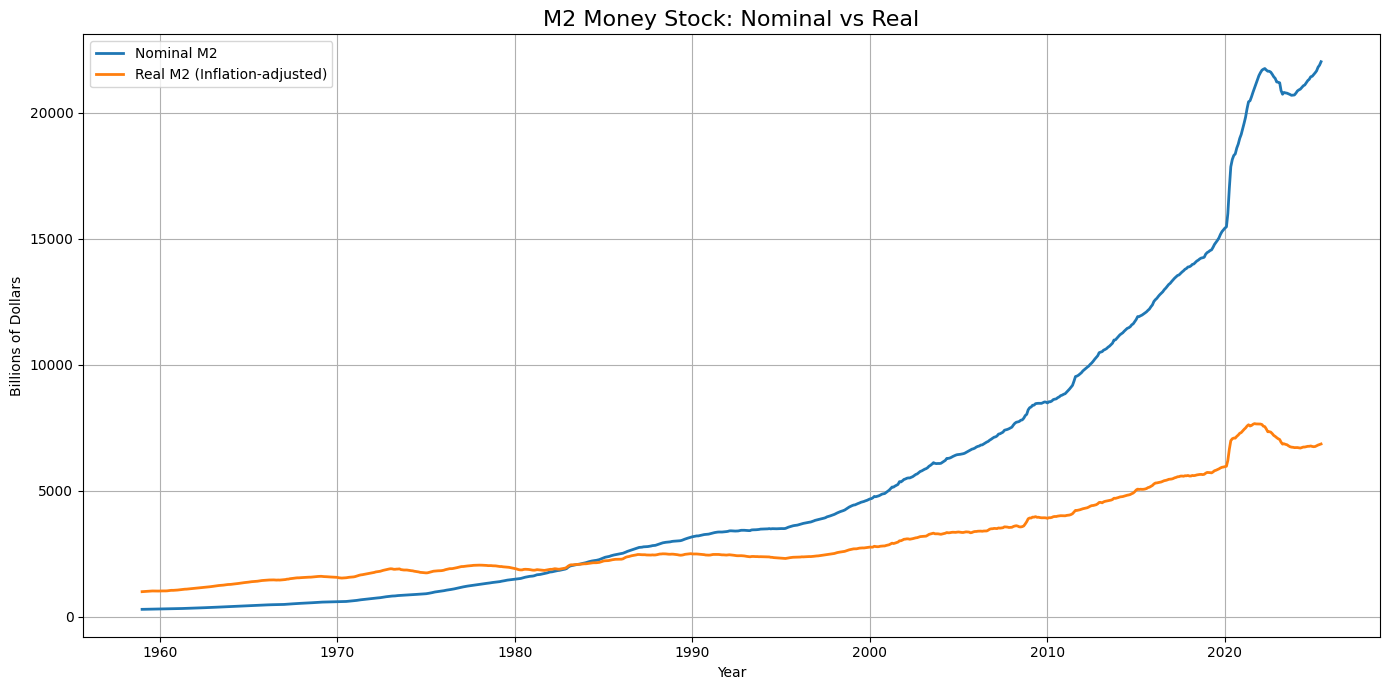

In [6]:
series = {
    "M2 Money Stock (Nominal)": "M2SL",
    "M2 Money Stock (Real)": "M2REAL"
}

# Download series
data = {name: fred.get_series(code) for name, code in series.items()}

# Combine into a single DataFrame
df = pd.DataFrame(data)
df.index.name = "Date"

# Trim to shared date range
df.dropna(inplace=True)

# Plot
plt.figure(figsize=(14, 7))
plt.plot(df.index, df["M2 Money Stock (Nominal)"], label="Nominal M2", linewidth=2)
plt.plot(df.index, df["M2 Money Stock (Real)"], label="Real M2 (Inflation-adjusted)", linewidth=2)
plt.title("M2 Money Stock: Nominal vs Real", fontsize=16)
plt.xlabel("Year")
plt.ylabel("Billions of Dollars")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

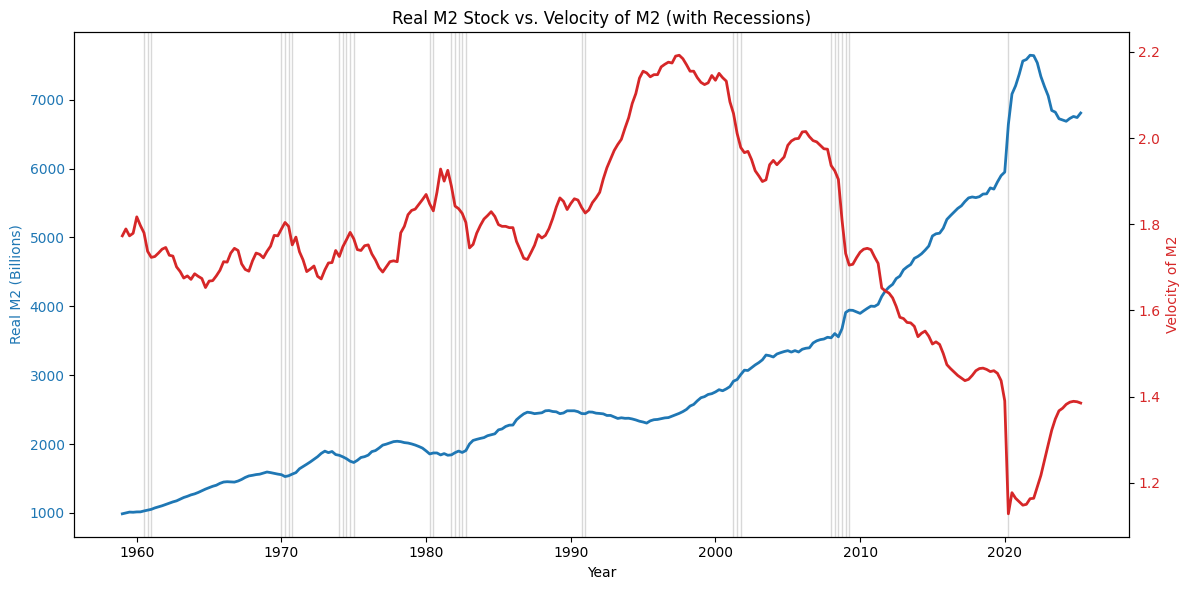

In [16]:
# --- Pull Data ---
real_m2 = fred.get_series("M2REAL")  # Real M2 Money Stock
velocity = fred.get_series("M2V")    # Velocity of M2
recessions = fred.get_series("USREC")  # NBER recession indicator

# Combine into one DataFrame
df = pd.concat([real_m2, velocity, recessions], axis=1)
df.columns = ["Real M2", "Velocity of M2", "USREC"]
df.dropna(inplace=True)

# --- Plot ---
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot Real M2 on left axis
ax1.set_xlabel("Year")
ax1.set_ylabel("Real M2 (Billions)", color="tab:blue")
ax1.plot(df.index, df["Real M2"], color="tab:blue", label="Real M2", linewidth=2)
ax1.tick_params(axis="y", labelcolor="tab:blue")

# Create second y-axis for velocity
ax2 = ax1.twinx()
ax2.set_ylabel("Velocity of M2", color="tab:red")
ax2.plot(df.index, df["Velocity of M2"], color="tab:red", label="Velocity of M2", linewidth=2)
ax2.tick_params(axis="y", labelcolor="tab:red")

# --- Shade recessions ---
for i in range(len(df)):
    if df["USREC"].iloc[i] == 1:
        ax1.axvspan(df.index[i], df.index[i], color="gray", alpha=0.3)

# A cleaner shading method:
recession_periods = df[df["USREC"] == 1]
if not recession_periods.empty:
    start_date = None
    for date, rec in recession_periods["USREC"].items():
        if rec == 1 and start_date is None:
            start_date = date
        elif rec == 0 and start_date is not None:
            ax1.axvspan(start_date, date, color="black", alpha=0.3)
            start_date = None

# Titles and legend
plt.title("Real M2 Stock vs. Velocity of M2 (with Recessions)", fontsize=12)
fig.tight_layout()
plt.show()
